## Part 1.2 Exploratory Data Analysis

#### Importing Libraries

In [ ]:
import pandas as pd

from sklearn.feature_selection import mutual_info_classif

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
plt.style.use('ggplot')
%matplotlib inline

import logging
logging.getLogger('matplotlib.category').setLevel(logging.ERROR)

ModuleNotFoundError: No module named 'pandas'

#### Dataset Preprocessing for Visualizations

In [ ]:
kidney_data = pd.read_csv('../Dataset/ckd-dataset-v2.csv')
kidney_data = kidney_data.loc[2:, :]
kidney_data = kidney_data.drop(columns=['affected'])

binary_vars = ['bp (Diastolic)', 'rbc', 'pc', 'pcc', 'ba', 'htn', 'dm', 'cad', 'appet', 'pe', 'ane', 'class']
ordinal_vars = [col for col in kidney_data.columns if col not in binary_vars]

In [ ]:
import re

def get_sorted_range_values(df, column_name):
    def get_sort_key(val):
        val = val.strip()
        if re.match(r'^<\s*\d+', val):
            return float(val.replace('<', '').strip()) - 1e-5
        elif re.match(r'^≥\s*\d+', val):
            return float(val.replace('≥', '').strip()) + 1e-5
        elif re.match(r'^\d+', val):
            parts = re.findall(r'\d+(?:\.\d+)?', val)
            if len(parts) == 2:
                return (float(parts[0]) + float(parts[1])) / 2
            elif len(parts) == 1:
                return float(parts[0])
        return float('inf')

    unique_values = df[column_name].dropna().unique()
    sorted_values = sorted(unique_values, key=get_sort_key)
    return sorted_values


#### Ordinal variables histogram plots

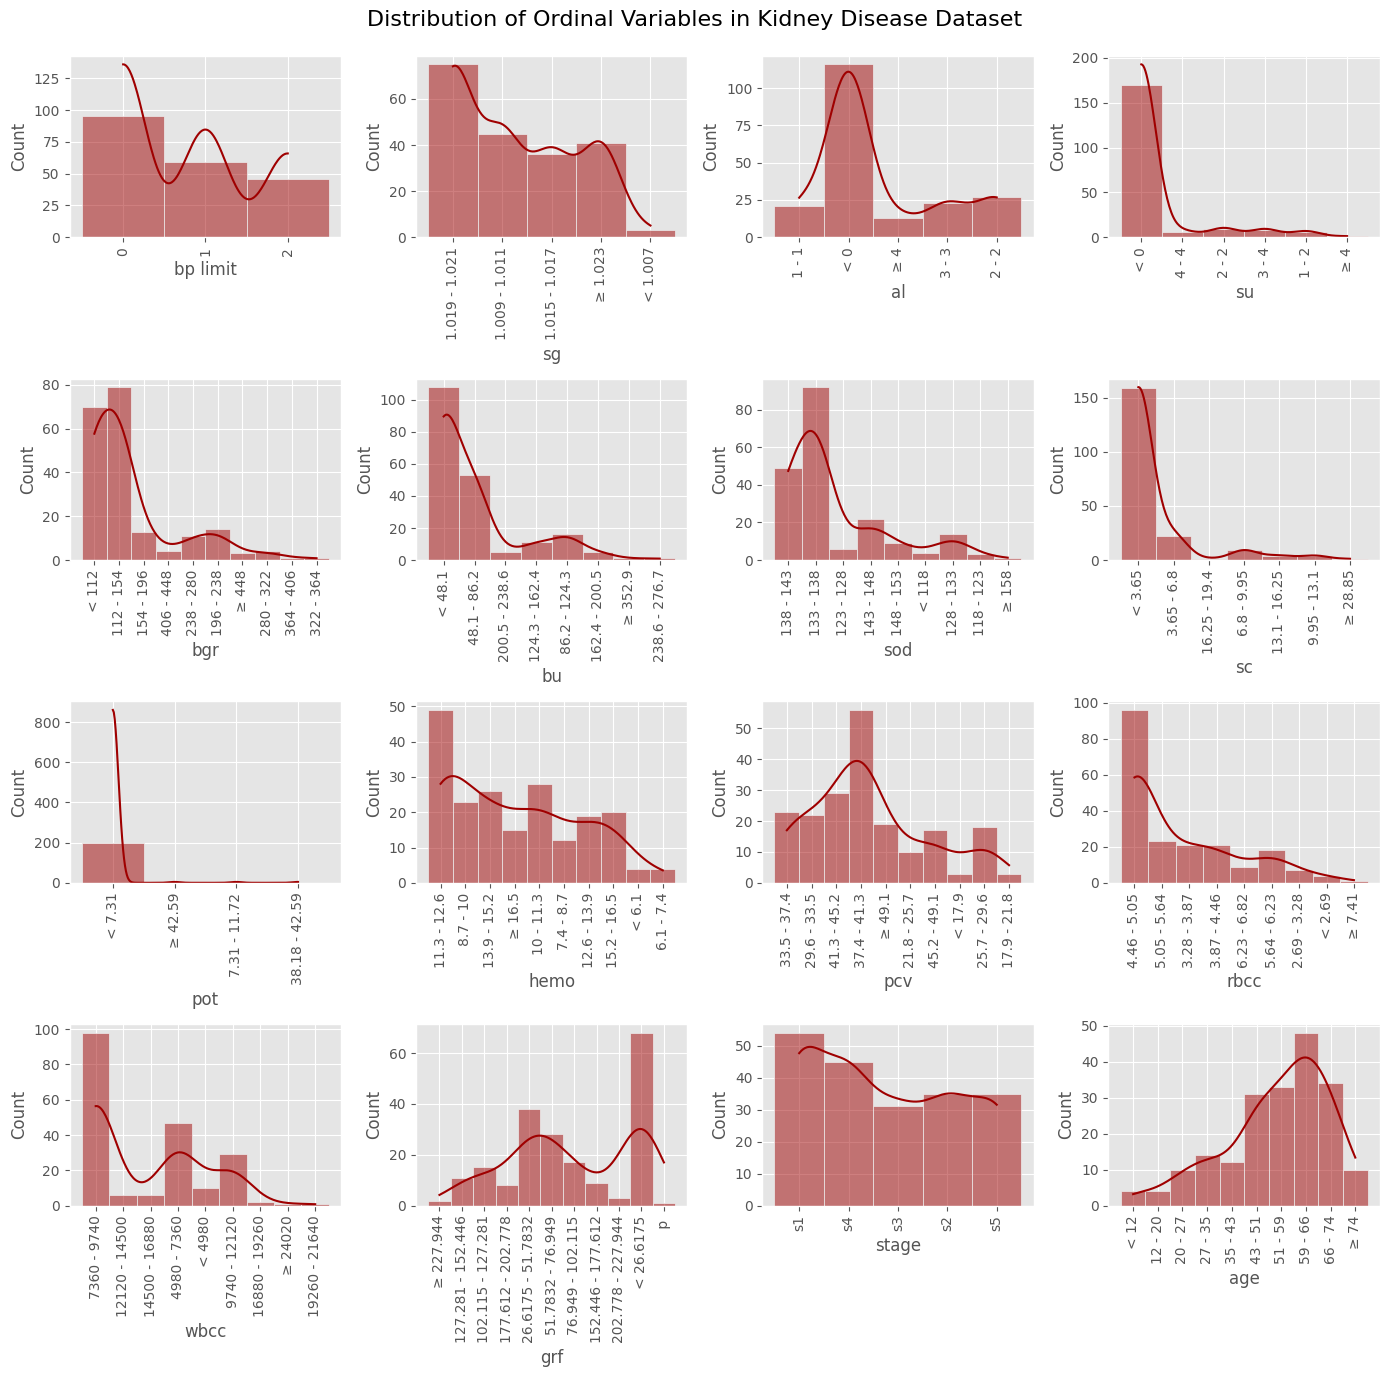

In [ ]:
plt.figure(figsize=(14, 14))
plotnumber = 1

for column in ordinal_vars:
    ax = plt.subplot(4, 4, plotnumber)
    plt.xlabel(column)
    sorted_order = get_sorted_range_values(kidney_data, column)
    sns.histplot(kidney_data, x=column, discrete=True, kde=True, color='#9f0000', alpha=0.5)
    plt.xticks(rotation=90)
    plotnumber += 1

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.suptitle('Distribution of Ordinal Variables', fontsize=16)
plt.show()


- The variable 'grf' contains an unknown value 'p'. In the encoded dataset, it is replaced by the mode value of the series, i.e. the interval category '<26.6175'.
- Variables like al, su, bgr, sc, and pot are more likely to be skewed toward one dominant category during inference.

#### Binary variables bar plots

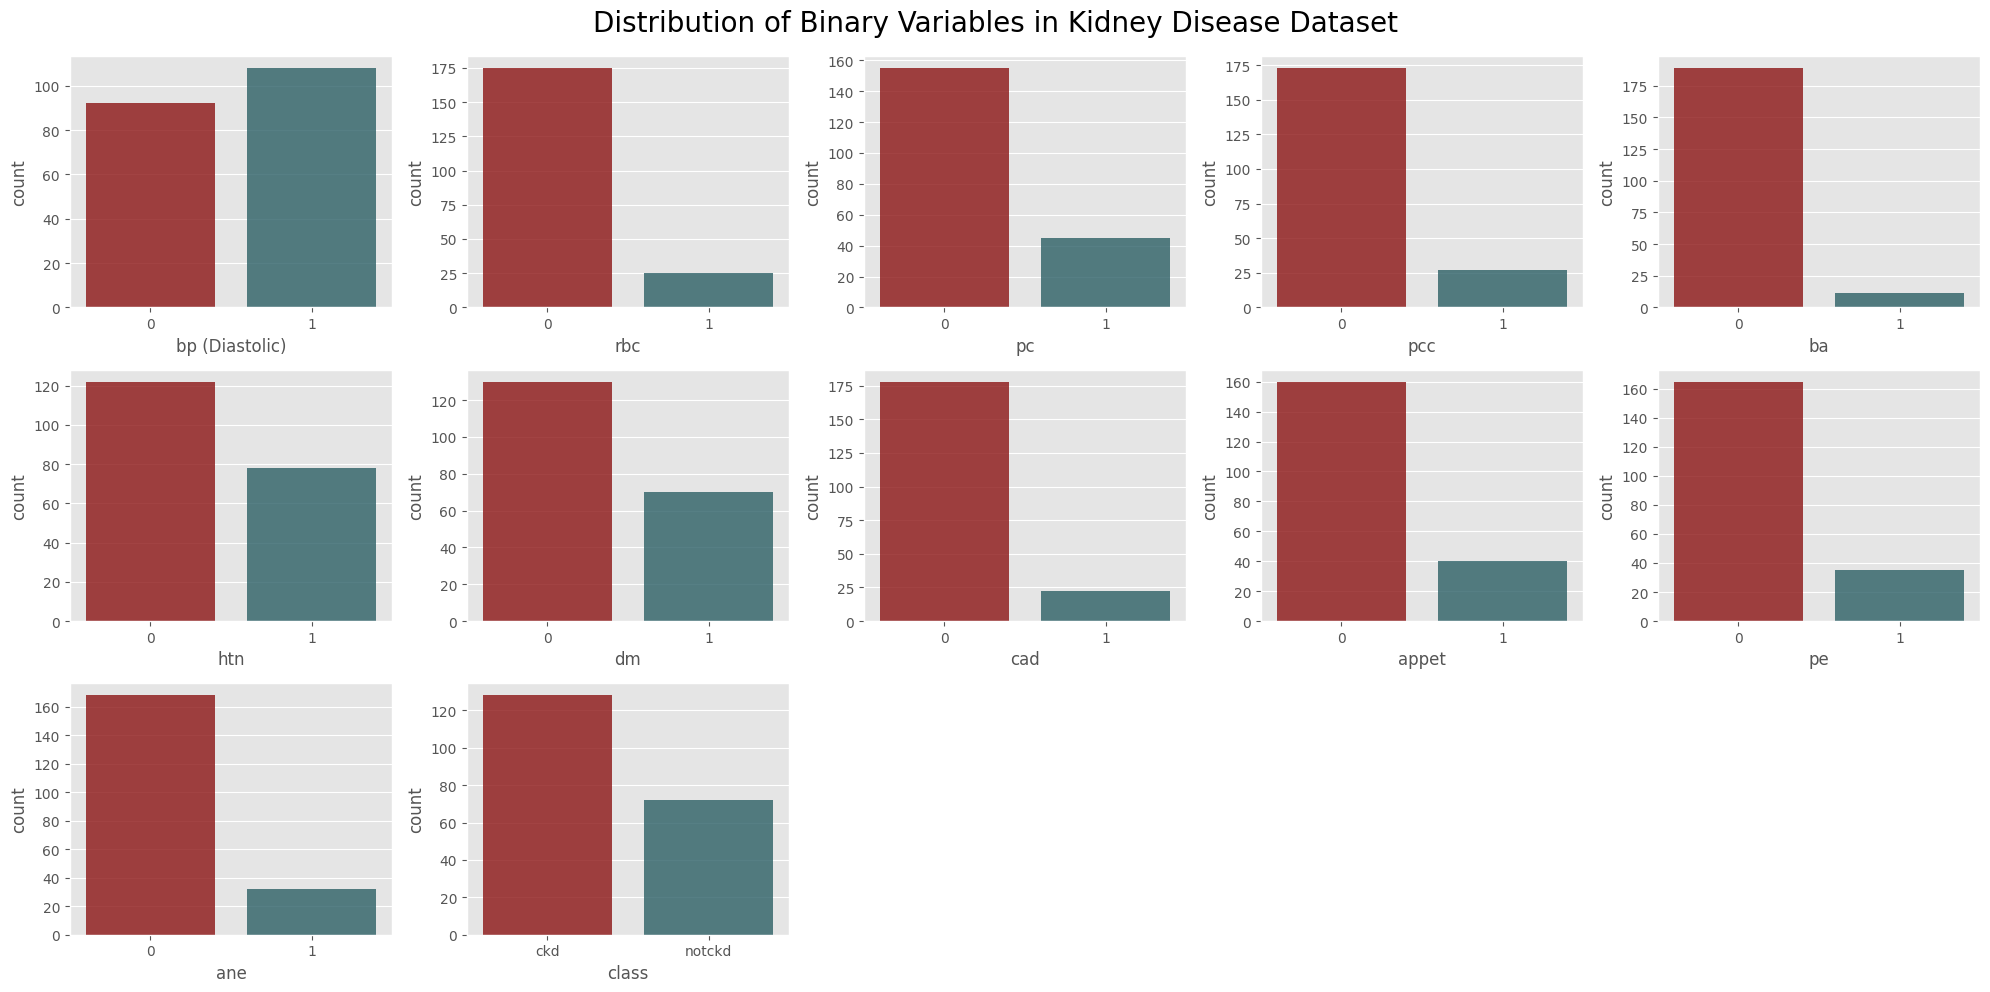

In [ ]:
plt.figure(figsize=(20, 16))
plotnumber = 1

for column in binary_vars:
    ax = plt.subplot(5, 5, plotnumber)
    plt.xlabel(column)
    sorted_order = get_sorted_range_values(kidney_data, column)
    sns.countplot(x=column, data=kidney_data, order=sorted_order, hue=column, palette=['#9f0000', '#22666F'], alpha=0.8)
    plotnumber += 1

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.suptitle('Distribution of Binary Variables', fontsize=20)
plt.show()


Variables like rbc, pcc, ba, cad, appet, pe and ane are more likely to be influenced by the dominant 0 category during inference.

#### Class Imbalance

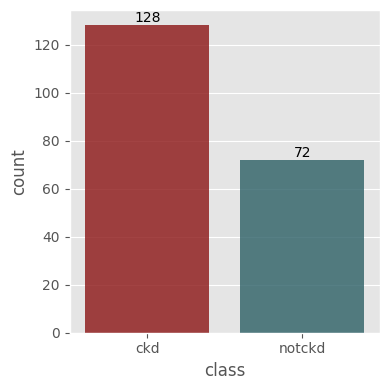

In [ ]:
plt.figure(figsize=(4, 4))

plt.xlabel('class')
class_bp = sns.countplot(x=kidney_data['class'], data=kidney_data, hue=kidney_data['class'], palette=['#9f0000', '#22666F'], alpha=0.8)
for container in class_bp.containers:
    class_bp.bar_label(container, fontsize=10)

plt.tight_layout()
plt.show()


In [ ]:
print(f"The dataset contains {kidney_data['class'].value_counts().iloc[0]} samples of ckd class and {kidney_data['class'].value_counts().iloc[1]} samples of notckd class.")

The dataset contains 128 samples of ckd class and 72 samples of notckd class.


The above bar chart depicts class imbalance in the dataset due to the presence of more records corresponding to the 'ckd' class as compared to the 'notckd' class. This moderate imbalance will be more dominant in individual client data partitions of the original data while working in the federated setting and will require necessary techniques to be handled. 

#### Correlation Analysis

In [ ]:
# Encoded data to support correlation analysis
kidney_data = pd.read_csv('../Dataset/cleaned_kidney_data.csv')

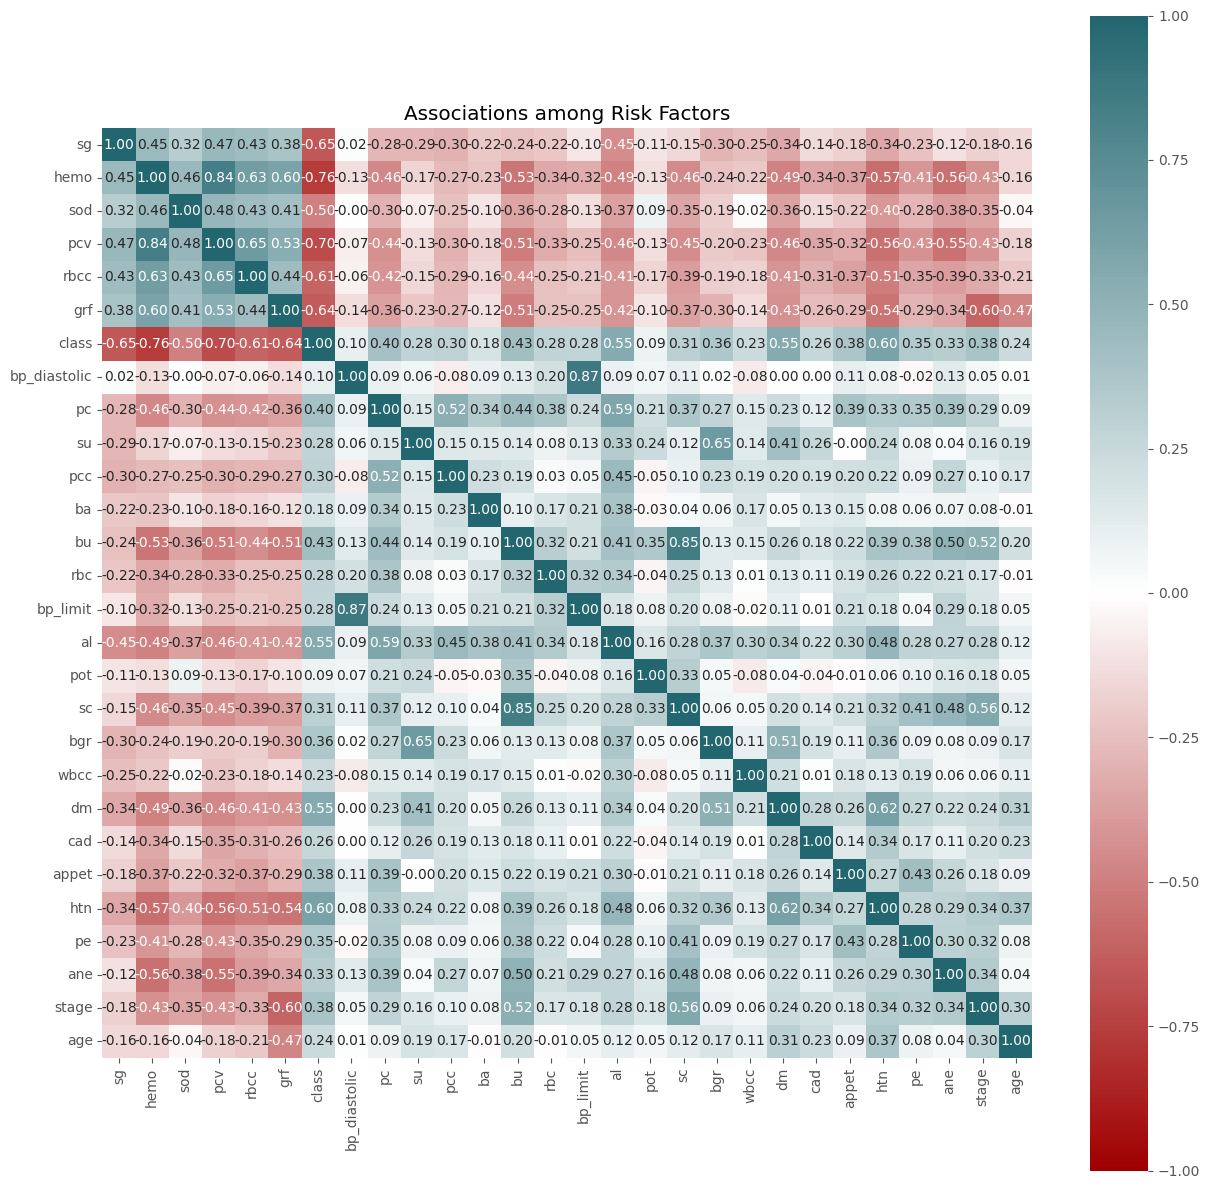

In [ ]:
# Heatmap of associations

from dython.nominal import associations

custom_cmap = LinearSegmentedColormap.from_list(
    'custom_diverging', 
    ['#9f0000', 'white', '#22666F']  
)

assoc_matrix = associations(
    kidney_data,
    figsize=(15, 15),
    plot=True,
    cmap=custom_cmap,
    annot=True,
    clustering=True,
    title='Associations among Risk Factors'
)

Clustering highlights the strongly associated risk factors, which in the next figure share similar correlation patterns with the class variable. For e.g. sg, hemo, sod, pcv, rbcc and grf are clustered together and are negatively correlated with the class variable.

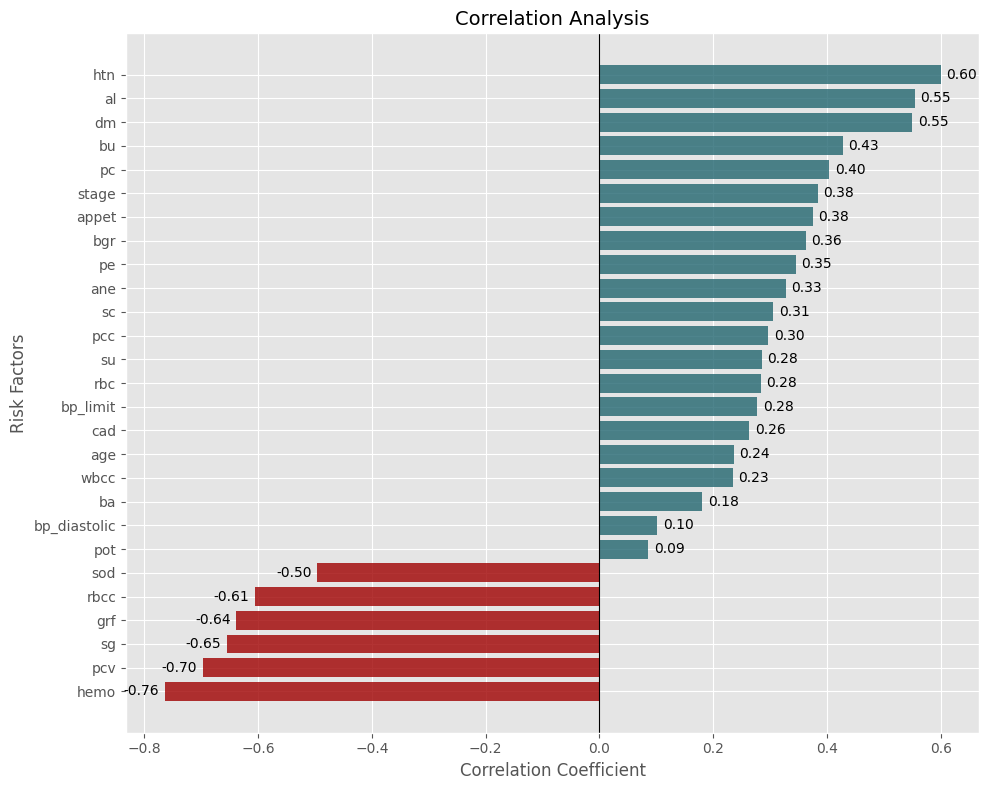

In [ ]:
# Visualizing correlation coefficients

corr_series = assoc_matrix['corr']['class']
corr_df = pd.DataFrame(corr_series).drop(index='class') 
corr_df = corr_df.rename(columns={'class': 'Correlation'})
corr_df = corr_df.sort_values(by='Correlation', ascending=True)

corr_df['Color'] = corr_df['Correlation'].apply(lambda x: '#9f0000' if x < 0 else '#22666F')

plt.figure(figsize=(10, 8))
bars = plt.barh(corr_df.index, corr_df['Correlation'], color=corr_df['Color'], alpha=0.8)

for bar in bars:
    plt.text(
        bar.get_width() + 0.01 * (-1 if bar.get_width() < 0 else 1),
        bar.get_y() + bar.get_height() / 2,
        f"{bar.get_width():.2f}",
        va='center',
        ha='left' if bar.get_width() > 0 else 'right',
        color='black'
    )

plt.title("Correlation Analysis", fontsize=14)
plt.axvline(0, color='black', linewidth=0.8)  
plt.xlabel("Correlation Coefficient")
plt.ylabel("Risk Factors")
plt.tight_layout()
plt.show()

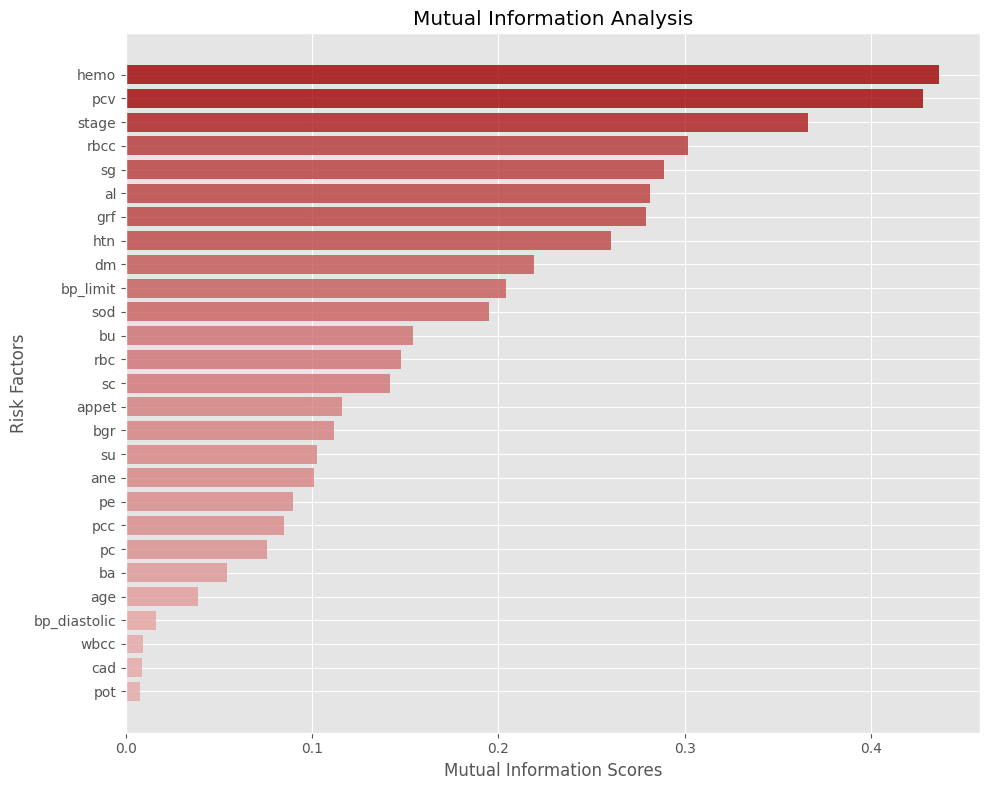

In [ ]:
# Mutual Information Analysis

X = kidney_data.drop(columns=['class'])
y = kidney_data['class']

mi_scores = mutual_info_classif(X, y, discrete_features='auto', random_state=42)

mi_df = pd.DataFrame({
    'Feature': X.columns,
    'Mutual Information Scores': mi_scores
}).sort_values(by='Mutual Information Scores', ascending=True)

custom_cmap = LinearSegmentedColormap.from_list(
    'custom_red', 
    ['#e5a7a5', '#9f0000']  
)

from matplotlib.colors import LinearSegmentedColormap, Normalize

norm = Normalize(vmin=mi_df['Mutual Information Scores'].min(), vmax=mi_df['Mutual Information Scores'].max())
colors = custom_cmap(norm(mi_df['Mutual Information Scores']))

plt.figure(figsize=(10, 8))
plt.barh(mi_df['Feature'], mi_df['Mutual Information Scores'], color=colors, alpha=0.8)
plt.xlabel('Mutual Information Scores')
plt.ylabel('Risk Factors')
plt.title('Mutual Information Analysis')
plt.tight_layout()
plt.show()
